# ◆[SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset)
### 目的：SMSメッセージのテキストから「スパム」または「ハム」に分類する。
###### Create Date：2020/01/17　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

#### 【手順】
0. [**Notebook内で利用する関数の定義**](#import_module)
1. [**データ読込**](#import_data)
2. [**特徴量の抽出**](#feature_extraction)
3. [**前処理**](#prepearing)
4. [**モデル構築と評価**](#modeling)
5. [**テストデータ予測**](#submission)

###### ※データセット「spam.csv」（データ数：5572, 2）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | v1→label |spam or hum | - | ○ |
|  2 | v2→text | SNS message | - | ○ |

## 0. Notebook内で利用する関数の定義<a id='import_module'></a>

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections             import Counter
from sklearn.svm             import SVC
from IPython.display         import Markdown, display
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import classification_report, confusion_matrix, accuracy_score
from sklearn                 import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')
    
# ============================================================================
# MarkDown記法
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))

# 1. データ読込<a id='import_data'><a>

In [2]:
df = pd.read_csv("./input/spam.csv",encoding='latin-1')
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df = df.rename(columns={"v1":"label", "v2":"text"})

printmd('▼サイズ')
print(df.shape)

printmd('▼先頭5行')
display(df.head(5))

printmd('▼基本統計量')
display(df.describe())



**▼サイズ**

(5572, 2)




**▼先頭5行**

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."




**▼基本統計量**

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# 2. 特徴量の抽出<a id='feature_extraction'></a>



**▼ 目的変数labelの種類（%）**

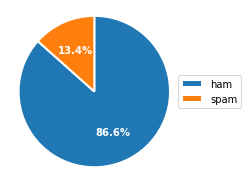



**▼ 件数（spam=1，ham=0）**

text                                                               
      count unique                                                top freq
label                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4



**▼ spam rate**

baseline=0.134


In [3]:
printmd('▼ 目的変数labelの種類（%）')
per_class = round(df['label'].value_counts() / len(df['label']) * 100,2)
values = list(per_class.values)

# 円グラフ
plt.figure(figsize=(3,3))
plt.pie(values, labels=list(per_class.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

df['label'] = df['label'].map({'ham': 0,'spam': 1})

printmd('▼ 件数（spam=1，ham=0）')
display(df.groupby('label').describe())

printmd('▼ spam rate')
baseline = df['label'].mean()
print('baseline={:.3f}'.format(baseline))


# 3. 前処理<a id='prepearing'></a>
## 3-1. More frequent words in non-spam messages



**▼出現回数が多い単語**

,words in non-spam,count
0,to,1530
1,you,1458
2,I,1436
3,the,1019
4,a,969


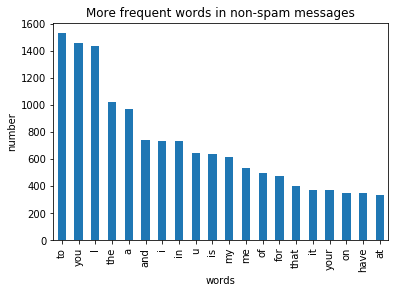

In [4]:
# non-spam

# 出現回数が多い順に要素を取得
count1 = Counter(" ".join(df[df['label']==0]['text']).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})

printmd('▼出現回数が多い単語')
display(df1.head(5))

df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

## 3-2. More frequent words in spam messages



**▼出現回数が多い単語**

,words in spam,count_
0,to,604
1,a,358
2,your,187
3,call,185
4,or,185


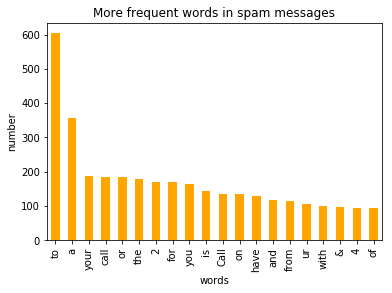

In [5]:
# spam

# 出現回数が多い順に要素を取得
count2 = Counter(" ".join(df[df['label']==1]['text']).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

printmd('▼出現回数が多い単語')
display(df2.head(5))

df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

## 3-3. 特徴量エンジニアリング
- テキストの前処理、トークン化、およびストップワードのフィルタリングは、機能の辞書を構築し、ドキュメントを機能ベクトルに変換できる高レベルのコンポーネントに含まれています。
- sklearnの[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)を使うとBoW(Bag of Words)の特徴量が簡単に作れます
- 分析を改善するためにストップワードを削除します


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.30, random_state=1234)

# テキストドキュメントのコレクションをトークンカウントのマトリックスに変換
f = CountVectorizer(stop_words = 'english')
X_train = f.fit_transform(X_train)
X_test = f.transform(X_test)

#print(np.shape(X_train))
#print(type(X_train))
#print(X_train)

# 4. モデル構築<a id='modeling'></a>
- ガウスカーネルでサポートベクターマシンモデルを適用する同じ推論を適用します。
- 正則化パラメーターCを変更してさまざまなモデルをトレーニングします。
- テストセットを使用して、モデルの精度、再現率、および精度を評価します。

In [7]:
list_C = np.arange(500, 2000, 100) #500～1000まで100刻みで増加

score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))

count = 0
for C in list_C:
    # 生成
    svc = svm.SVC(C=C, kernel='rbf', gamma='auto_deprecated')
    # 学習
    svc.fit(X_train, y_train)
    
    # 結果を格納
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    
    count = count + 1 

# 5. モデル評価<a id='model_evaluation'></a>

In [8]:
# 行列に格納
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])

# DataFrameに格納
models = pd.DataFrame(data=matrix, columns=['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])

# テスト結果一覧
display(models.head(n=10))

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,0.995641,0.979067,0.852941,1.000000
1,600.0,0.996410,0.979067,0.852941,1.000000
2,700.0,0.997436,0.978469,0.848739,1.000000
3,800.0,0.997692,0.979067,0.852941,1.000000
4,900.0,0.997949,0.979067,0.852941,1.000000
5,1000.0,0.997949,0.978469,0.852941,0.995098
6,1100.0,0.998462,0.978469,0.852941,0.995098
7,1200.0,0.999231,0.979067,0.857143,0.995122
8,1300.0,0.999231,0.979665,0.861345,0.995146
9,1400.0,0.999231,0.980861,0.865546,1.000000


In [9]:
printmd('▼ モデルの評価結果')
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
svc = svm.SVC(C=list_C[best_index])
svc.fit(X_train, y_train)
print(models.iloc[best_index, :])

m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
conf_mat = pd.DataFrame(data = m_confusion_test,index = ['正解 hum:0', '正解 spam:1'], 
                                              columns = ['予測 hum:0', '予測 spam:1'])
display(conf_mat)



**▼ モデルの評価結果**

C                 1400.000000
Train Accuracy       0.999231
Test Accuracy        0.980861
Test Recall          0.865546
Test Precision       1.000000
Name: 9, dtype: float64


,予測 hum:0,予測 spam:1
正解 hum:0,1434,0
正解 spam:1,32,206


## 結論
- 最良のモデルは、98.0％の精度のサポートベクターマシン
- すべての非スパムメッセージを正しく分類します（モデルの精度）
- スパムメッセージの87.7％を正しく分類します（モデルのリコール）